<a href="https://colab.research.google.com/github/irravasyuk/SQL_2/blob/master/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BC%D0%B5%D1%80%D0%B5%D0%B6%D1%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [80]:
import pandas as pd
import torch

Дані про морське вухо(молюск)

<div>
<img src="https://m.media-amazon.com/images/I/81-FC5TlLtL.jpg" width="500"/>
</div>

In [81]:
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/abalone.csv')
df.drop(columns=['Type', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight'], inplace=True)

In [82]:
df.head()

,LongestShell,Diameter,Height,Rings
0,0.455,0.365,0.095,15
1,0.350,0.265,0.090,7
2,0.530,0.420,0.135,9
3,0.440,0.365,0.125,10
4,0.330,0.255,0.080,7


In [83]:
df.shape

(4177, 4)

In [84]:
df.describe()

,LongestShell,Diameter,Height,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,9.933684
std,0.120093,0.099240,0.041827,3.224169
min,0.075000,0.055000,0.000000,1.000000
25%,0.450000,0.350000,0.115000,8.000000
50%,0.545000,0.425000,0.140000,9.000000
75%,0.615000,0.480000,0.165000,11.000000
max,0.815000,0.650000,1.130000,29.000000


Потрібно на основі розмірів молюска спрогнозувати кількість кілець в мушлі `Rings`. Використовуйте процесор cpu

# Завдання 1
Створіть клас Dataset

In [85]:
import pandas as pd
import torch
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values).to(device)
        self.y = torch.FloatTensor(y.values).to(device)
        self.y = self.y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X = df.drop(columns=['Rings'])
y = df['Rings']

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [86]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset,  # датасет з даними
                        batch_size=batch_size,  # кількість даних в одному пакеті
                        shuffle=True,  # чи треба перемішувати дані
                        generator=torch.Generator(device=device)) # підключення до процесора)

In [87]:
X_batch, y_batch = next(iter(dataloader))

In [88]:
X_batch.shape

torch.Size([128, 3])

In [89]:
y_batch.shape

torch.Size([128, 1])

In [90]:
X_batch.device

device(type='cpu')

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-3
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [91]:
from torch import nn


model = nn.Sequential(
    nn.Linear(3, 7),
    nn.ReLU(),
    nn.Linear(7, 4),
    nn.ReLU(),
    nn.Linear(4, 1)

)

model

Sequential(
  (0): Linear(in_features=3, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [92]:
from torchsummary import summary

summary(model, input_size=(3,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 7]              28
              ReLU-2                    [-1, 7]               0
            Linear-3                    [-1, 4]              32
              ReLU-4                    [-1, 4]               0
            Linear-5                    [-1, 1]               5
Total params: 65
Trainable params: 65
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [93]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [94]:
import numpy as np

num_epochs = 10
losses = []

for epoch in range(num_epochs):
  losses_ = []
  for X_batch, y_batch in dataloader:
        # пряме поширення
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward() # рахуємо градієнти
        optimizer.step()
        optimizer.zero_grad()

  losses.append(np.mean(losses_))

  if epoch % 1 == 0:
          print(f'loss={losses[-1]}')

loss=98.00554957534328
loss=40.57365235415372
loss=9.107727484269576
loss=8.752861311941436
loss=8.711357246745717
loss=8.569679635943789
loss=8.592646266474869
loss=8.526252428690592
loss=8.450790246327719
loss=8.370825637470592


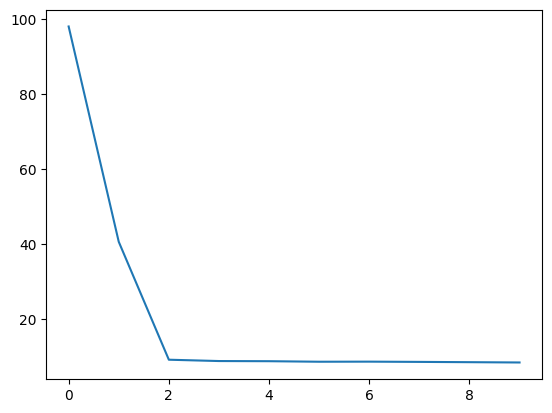

In [95]:
import matplotlib.pyplot as plt

plt.plot(losses)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [96]:
torch.save(model, 'model.pt')

In [97]:
load_model = torch.load('model.pt')

In [98]:
load_model

Sequential(
  (0): Linear(in_features=3, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [99]:
X.iloc[:1]

,LongestShell,Diameter,Height
0,0.455,0.365,0.095


In [100]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.4550, 0.3650, 0.0950]])
torch.Size([1, 3])


In [101]:
load_model(X_data)

tensor([[9.6611]], grad_fn=<AddmmBackward0>)